<a href="https://colab.research.google.com/github/pedrofernandss/CIS_4Periodo/blob/main/CIS_4Periodo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
dataset = '/content/drive/MyDrive/CIS_4Periodo/dados'
dir_treinamento = '/content/drive/MyDrive/CIS_4Periodo/dados/treinamento'
dir_teste = '/content/drive/MyDrive/CIS_4Periodo/dados/teste'

# Pré processamento

Em um primeiro momento, vamos usar o método ImageDataGenerator para definir os parametros de forma que nosso dataset de treinamento sofrerá, de maneira aleatória, zoom's, rotações, reescalonamento de cores e etc

In [ ]:
treinamento_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.3,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2)

Em seguida, aplicamos o mesmo método para que nosso dataset de teste sofra apenas um reescalonamento de cor (intervalo rgb passará a ser entre 0 e 1)

In [ ]:
teste_datagen = ImageDataGenerator(rescale=1./255)

vamos definir nossos dataset's de treinamento, validação e teste. Todos foram possuiram seu diretorio de origem indicados, imagens ajustadas para tamanho 150x150 e treinamento e testes foram embaralhados.

In [ ]:
treinamento_generator = treinamento_datagen.flow_from_directory(
    directory = dir_treinamento,
    target_size= (150,150),
    color_mode= 'rgb',
    batch_size= 32,
    classes=['cats', 'dogs', 'panda'],
    class_mode= 'categorical',
    subset= 'training',
    shuffle= True,
    seed=42
)

validacao_generator = treinamento_datagen.flow_from_directory(
    directory = dir_treinamento,
    target_size= (150,150),
    color_mode= 'rgb',
    batch_size= 32,
    classes=['cats', 'dogs', 'panda'],
    class_mode= 'categorical',
    subset= 'validation',
    shuffle= True,
    seed=42
)

teste_generator = teste_datagen.flow_from_directory(
    directory = dir_teste,
    target_size= (150,150),
    color_mode= 'rgb',
    batch_size= 32,
    classes=['cats', 'dogs', 'panda'],
    class_mode= 'categorical',
    shuffle= False,
    seed=42
)

Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# CNN

Ao criar nossa CNN, vamos determinar que ela possui 1 camada de input, 2 camadas ocultas e 1 camada de output. Além de realizar a normalização dos batch's.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(5,5), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32,(5,5), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(treinamento_generator,
          validation_data = validacao_generator,
          steps_per_epoch = treinamento_generator.samples // 32,
          validation_steps = validacao_generator.samples // 32,
          epochs=10)

Epoch 1/10
60/60 [==============================] - 1046s 17s/step - loss: 0.8932 - accuracy: 0.5932 - val_loss: 0.9065 - val_accuracy: 0.5354
Epoch 2/10
60/60 [==============================] - 166s 3s/step - loss: 0.7321 - accuracy: 0.6401 - val_loss: 0.9349 - val_accuracy: 0.4854
Epoch 3/10
60/60 [==============================] - 160s 3s/step - loss: 0.7276 - accuracy: 0.6370 - val_loss: 1.3113 - val_accuracy: 0.4062
Epoch 4/10
60/60 [==============================] - 167s 3s/step - loss: 0.6892 - accuracy: 0.6490 - val_loss: 1.3916 - val_accuracy: 0.3875
Epoch 5/10
60/60 [==============================] - 172s 3s/step - loss: 0.7103 - accuracy: 0.6453 - val_loss: 0.7143 - val_accuracy: 0.6458
Epoch 6/10
60/60 [==============================] - 170s 3s/step - loss: 0.6612 - accuracy: 0.6849 - val_loss: 0.8470 - val_accuracy: 0.5896
Epoch 7/10
60/60 [==============================] - 172s 3s/step - loss: 0.6364 - accuracy: 0.6948 - val_loss: 0.7950 - val_accuracy: 0.6438
Epoch 8/10


<function matplotlib.pyplot.show(close=None, block=None)>

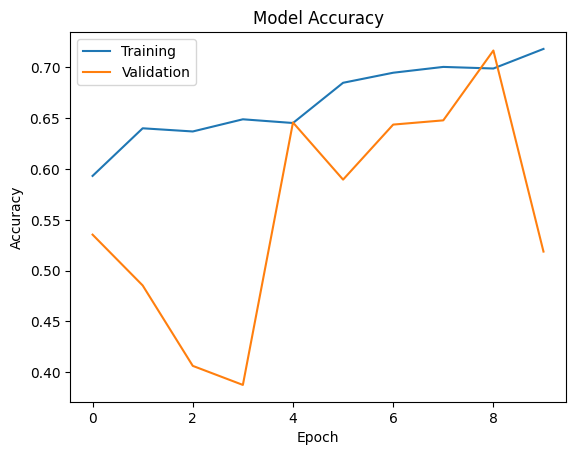

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show

In [ ]:
score = model.evaluate(teste_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

19/19 [==============================] - 317s 18s/step - loss: 0.7569 - accuracy: 0.6567
Test loss: 0.7568753957748413
Test accuracy: 0.6566666960716248


Ao realizar o treinamento e teste, verificamos que o algoritmo não possui uma perfomance tão satisfatória tanto no que diz respeito em tempo de execução de trainemento como em acurácia. Vamos tentar aplicar a técnica de dropout para tentar solucionar o problema de tempo d execução.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(32,(5,5), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(5,5), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model.fit(treinamento_generator,
          validation_data = validacao_generator,
          steps_per_epoch = treinamento_generator.samples // 32,
          validation_steps = validacao_generator.samples // 32,
          epochs=10)

Epoch 1/10
60/60 [==============================] - 182s 3s/step - loss: 3.7767 - accuracy: 0.3510 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/10
60/60 [==============================] - 181s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/10
60/60 [==============================] - 179s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/10
60/60 [==============================] - 167s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/10
60/60 [==============================] - 182s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/10
60/60 [==============================] - 168s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/10
60/60 [==============================] - 171s 3s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 8/10
60

<function matplotlib.pyplot.show(close=None, block=None)>

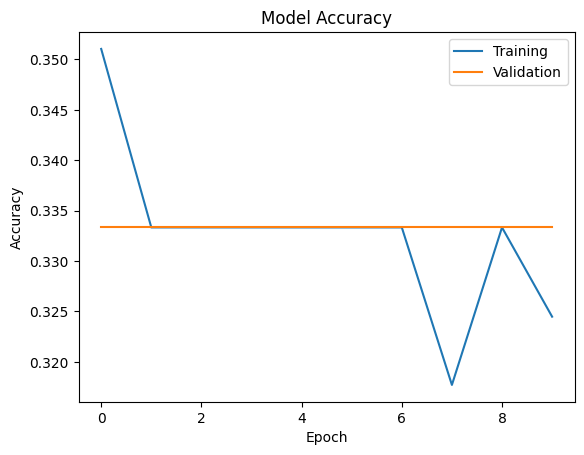

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show

In [ ]:
score2 = model.evaluate(teste_generator)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

19/19 [==============================] - 11s 551ms/step - loss: 1.0986 - accuracy: 0.3333
Test loss: 1.098616600036621
Test accuracy: 0.3333333432674408


Ao re-executar o algoritmo, é possível observar que houve uma queda no tempo de execução (tanto no treinamento como no teste) porém a acurácia também foi menor. Acredita-se que isso ocorre devido a quantidade de neurônios ativados serem menores.

Para tentar solucionar esse problema de acurácia, vamos utilizar o aprendizado pro transferência.

# Aprendizado por transferência

In [ ]:
modelo_base = keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in modelo_base.layers:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential()
model.add(modelo_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_10 (Dropout)        (None, 51200)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                1638432   
                                                                 
 batch_normalization_30 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(treinamento_generator,
          validation_data = validacao_generator,
          steps_per_epoch = treinamento_generator.samples // 32,
          validation_steps = validacao_generator.samples // 32,
          epochs=5)

Epoch 1/5
60/60 [==============================] - 287s 5s/step - loss: 0.1074 - accuracy: 0.9609 - val_loss: 0.0897 - val_accuracy: 0.9667
Epoch 2/5
60/60 [==============================] - 287s 5s/step - loss: 0.0917 - accuracy: 0.9682 - val_loss: 0.1292 - val_accuracy: 0.9500
Epoch 3/5
60/60 [==============================] - 284s 5s/step - loss: 0.0946 - accuracy: 0.9672 - val_loss: 0.1251 - val_accuracy: 0.9563
Epoch 4/5
60/60 [==============================] - 284s 5s/step - loss: 0.0745 - accuracy: 0.9708 - val_loss: 0.1467 - val_accuracy: 0.9438
Epoch 5/5
60/60 [==============================] - 289s 5s/step - loss: 0.0680 - accuracy: 0.9776 - val_loss: 0.0958 - val_accuracy: 0.9667


In [ ]:
score = model.evaluate(teste_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

19/19 [==============================] - 62s 3s/step - loss: 0.1027 - accuracy: 0.9650
Test loss: 0.10273013263940811
Test accuracy: 0.9649999737739563


# Conclusão

Em um primeiro momento, com a utilização apenas da técnica de batch normalization, houve uma demora grande na execução do algoritmo e uma baixa acurácia.

Para solucionar esse problema, adicionams a técnica de técnica de dropout, o tempo de execução foi menor, entretanto, houve uma queda na performance do algoritmo.

Por fim, para corrigir a queda de acurácia, utilizamos a técnica de transfer learning com o algoritmo de Xception o que possibilitou um aumento de acurácia bastante expressivo.